In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Imports

In [2]:
import sys
# sys.path.remove('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/master/helper_functions')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/master/helper_functions')

In [3]:
for p in sys.path:
  print(p)


/content
/env/python
/usr/lib/python37.zip
/usr/lib/python3.7
/usr/lib/python3.7/lib-dynload
/usr/local/lib/python3.7/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.7/dist-packages/IPython/extensions
/root/.ipython
/content/drive/MyDrive/Colab Notebooks/W266 Final Project/master/helper_functions


In [4]:
import pandas as pd
import numpy as np
import time
import pickle


import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import Word2Vec
#https://www.dezyre.com/recipes/use-word2vec#:~:text=How%20to%20use%20word2vec%3F%201%20Import%20the%20necessary,the%20escape%20character%20with%20spaces%20More%20items...%20
#https://radimrehurek.com/gensim_3.8.3/models/word2vec.html
# https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

import parse

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
df = pd.read_csv (r'/content/drive/MyDrive/Colab Notebooks/W266 Final Project/data/raw_data_preprocessed.csv')
df.head(2)

,question_id,question_title_raw,question_body_raw,question_body,question_body_text,question_body_code,question_title_body_raw,question_title_body,question_title_body_text,question_title_body_code,answer_id,answer_body_raw,answer_body,answer_text,answer_code,answer_count,view_count,answer_score,is_accepted_answer
0,55661532,"When I run my socket program, there get: `impo...",<p>I write a socket server programmer:</p>\n\n...,I write a socket server programmer:\n#-*- codi...,I write a socket server programmer:\n\nwhen I ...,#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,"When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...",#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,55661630,<p>The answer to your new question is that you...,The answer to your new question is that you ca...,The answer to your new question is that you ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,1816,0,0
1,55661626,"with socket.socket(socket.AF_INET, socket.SOCK...",<p>I have a socket server program:</p>\n\n<pre...,I have a socket server program:\n#!/usr/bin/en...,I have a socket server program:\n\nwhen I run ...,#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,"with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...",#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,55661660,<p>You can't use <code>socket.socket(socket.AF...,"You can't use socket.socket(socket.AF_INET, so...",You can't use with . So that a statement ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,2521,0,1


# EDA on Title_Body


QUESTION STATS
Min: 3
Max: 3037
Average: 135.2772805621851
fraction of zeros: 0.0


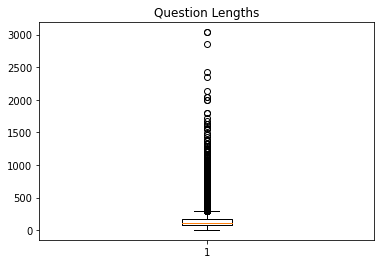

In [6]:
#EDA 

import matplotlib.pyplot as plt

#Get question title lengths
question_lengths = []
for item in df['question_title_body']:
    question_lengths.append(len(str(item).split()))

#Calculate average
question_lengths_average = sum(question_lengths)/len(question_lengths)

#Count # of zeros
zeros=0
for each in question_lengths:
  if each == 0:
    zeros+=1

print("QUESTION STATS")
print("Min:", min(question_lengths))
print("Max:", max(question_lengths))
print("Average:", question_lengths_average)
print("fraction of zeros:", zeros/len(question_lengths))

# #Plot histogram
# plt.hist(question_RWords_lengths, density=False, bins=50) 
# plt.ylabel('Count')
# plt.xlabel('Length')
# plt.title('Question RWords Lengths')

#Plot boxplot 
plt.boxplot(question_lengths) 
plt.title('Question Lengths')
plt.show() 


Answer RWords STATS
Min: 1
Max: 3509
Average: 87.27467846725007
fraction of zeros: 0.0


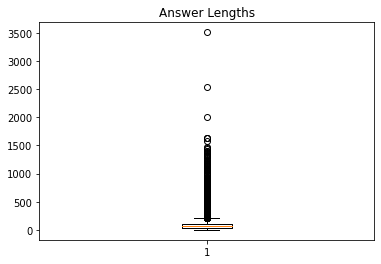

In [7]:
#EDA 

import matplotlib.pyplot as plt

#Get question title lengths
answer_lengths = []
for item in df['answer_body']:
    answer_lengths.append(len(str(item).split()))

#Calculate average
answer_lengths_average = sum(answer_lengths)/len(answer_lengths)

#Count # of zeros
zeros=0
for each in answer_lengths:
  if each == 0:
    zeros+=1

print("Answer RWords STATS")
print("Min:", min(answer_lengths))
print("Max:", max(answer_lengths))
print("Average:", answer_lengths_average)
print("fraction of zeros:", zeros/len(answer_lengths))

# #Plot histogram
# plt.hist(answer_RWords_lengths, density=False, bins=50) 
# plt.ylabel('Count')
# plt.xlabel('Length')
# plt.title('Answer RWords Lengths')

#Plot boxplot 
plt.boxplot(answer_lengths) 
plt.title('Answer Lengths')
plt.show() 


# Create word2vec training data

In [8]:
#Load training dataset
train_from_file = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/data/q_a_dict_train.pickle', 'rb')
train_qa_dict = pickle.load(train_from_file)
train_question_ids = list(train_qa_dict.keys())
df_train = df[df['question_id'].isin(train_question_ids)]
print(df_train.shape)
df_train = df_train.reset_index()
df_train.head(3)

(48309, 19)


,index,question_id,question_title_raw,question_body_raw,question_body,question_body_text,question_body_code,question_title_body_raw,question_title_body,question_title_body_text,question_title_body_code,answer_id,answer_body_raw,answer_body,answer_text,answer_code,answer_count,view_count,answer_score,is_accepted_answer
0,0,55661532,"When I run my socket program, there get: `impo...",<p>I write a socket server programmer:</p>\n\n...,I write a socket server programmer:\n#-*- codi...,I write a socket server programmer:\n\nwhen I ...,#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,"When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...",#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,55661630,<p>The answer to your new question is that you...,The answer to your new question is that you ca...,The answer to your new question is that you ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,1816,0,0
1,1,55661626,"with socket.socket(socket.AF_INET, socket.SOCK...",<p>I have a socket server program:</p>\n\n<pre...,I have a socket server program:\n#!/usr/bin/en...,I have a socket server program:\n\nwhen I run ...,#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,"with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...",#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,55661660,<p>You can't use <code>socket.socket(socket.AF...,"You can't use socket.socket(socket.AF_INET, so...",You can't use with . So that a statement ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,2521,0,1
2,3,55662778,create list with spectial type - Spyder error ...,<p>I want to print <code>&gt;</code> in the sc...,I want to print > in the script 0 to test the ...,I want to print in the script 0 to test the c...,>script[0][4][2]name 'script' is not defined\n...,create list with spectial type - Spyder error ...,create list with spectial type - Spyder error ...,create list with spectial type - Spyder error ...,>script[0][4][2]name 'script' is not defined\n...,55662821,<p>Define list as <code>[]</code> and use <cod...,Define list as [] and use append to add elemen...,Define list as and use to add elements to li...,"[]appendscript = []\n\nscript.append(['A','A',...",2,24,0,1


In [9]:
#Create training examples (1 example for testing)

#Remove \n characters
idx=9
s_question = df_train.question_title_body[idx]

#Tokenize data
data_question = []

# Separate by sentences, then separate by tokens
for i in sent_tokenize(s_question):
    temp = []
    for j in word_tokenize(i):
        temp.append(j.lower()) 
    data_question.append(temp)

print(s_question)
print(data_question)

Trying to find sum of digits between two numbersTrying to figure out how to find the sum of digits between two numbers(including those numbers) using a function in python. 
I tried recursion for each individual argument and then subtracted them to compensate for the numbers in between. Then I added these two and got my sum, which is incorrect for every argument unless the digits are below 10. Not sure of the proper way to approach this problem, please help.
def sum_digits(a, b):
"""sum of digits between two numbers"""
  sum = 0
  ones = a - b
  if ones < 0:
    ones = ones * -1


  if a >= 10 and b >= 10:
    sum += ones


  while a > 0 and b > 0:
    d = a % 10 + b % 10
    a = a // 10
    b = b // 10
    sum += d

  return sum

[['trying', 'to', 'find', 'sum', 'of', 'digits', 'between', 'two', 'numberstrying', 'to', 'figure', 'out', 'how', 'to', 'find', 'the', 'sum', 'of', 'digits', 'between', 'two', 'numbers', '(', 'including', 'those', 'numbers', ')', 'using', 'a', 'function', 'in'

In [12]:
train_sentences = []

start=time.time()

for idx in range(0,df_train.shape[0]):
  
  #Remove \n characters (if any)
  s_question = df_train.question_title_body[idx]
  f_question = s_question.replace("\n", " ")
  s_answer = df.answer_body[idx]
  f_answer = s_answer.replace("\n", " ")

  #Tokenize data
  data_question = []
  data_answer = []
  # Separate by sentences, then separate by tokens
  for i in sent_tokenize(f_question):
      temp = []
      for j in word_tokenize(i):
          temp.append(j.lower()) 
      data_question.append(temp)
  for i in sent_tokenize(f_answer):
      temp = []
      for j in word_tokenize(i):
          temp.append(j.lower())
      data_answer.append(temp)
  
  for each in data_question:
    train_sentences.append(each)
  for each in data_answer:
    train_sentences.append(each)
  
print(time.time()-start, "seconds")

125.57312774658203 seconds


In [13]:
print(train_sentences[2])

['#', '!', '/usr/bin/env', 'python', 'when', 'i', 'run', 'the', 'script', ',', 'there', 'gets', 'this', 'error', ':', 'sele-macbook-pro', ':', 'test01', 'ldl', '$', './tests02-server.py', 'traceback', '(', 'most', 'recent', 'call', 'last', ')', ':', 'file', '``', './tests02-server.py', "''", ',', 'line', '11', ',', 'in', '<', 'module', '>', 'with', 'socket.socket', '(', 'socket.af_inet', ',', 'socket.sock_stream', ')', 'as', 's', ':', 'attributeerror', ':', '__exit__', 'aircrafts-macbook-pro', ':', 'test01', 'ldl', '$', './tests02-server.py', 'traceback', '(', 'most', 'recent', 'call', 'last', ')', ':', 'file', '``', './tests02-server.py', "''", ',', 'line', '11', ',', 'in', '<', 'module', '>', 'with', 'socket.socket', '(', 'socket.af_inet', ',', 'socket.sock_stream', ')', 'as', 's', ':', 'attributeerror', ':', '__exit__']


In [14]:
print(len(train_sentences))

390657


# Train Word2Vec on TEXT & CODE

In [15]:
#Specify parameters for model

import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print("cores:",cores)

dimension= 135 #based on average question title body length

model1 = gensim.models. Word2Vec(min_count=1,
                                  window=5,
                                  size=dimension,
                                  # sample=6e-5, 
                                  alpha=0.03, 
                                  min_alpha=0.0007, 
                                  # negative=20,
                                  workers=cores-1)


# min_count = int - Ignores all words with total absolute frequency lower than this - (1, 100)
# window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
# size = int - Dimensionality of the feature vectors. - (50, 300)
# sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
# alpha = float - The initial learning rate - (0.01, 0.05)
# min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
# negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
# workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

model1.save("py2vec.model")

cores: 4


In [16]:
start=time.time()
# Build vocabulary
py2vec=Word2Vec.load("py2vec.model")
py2vec.build_vocab(train_sentences, progress_per=10000)
print(py2vec.corpus_count)
py2vec.save("py2vec.model")

print(time.time()-start, "seconds")


390657
65.33568739891052 seconds


In [20]:
start=time.time()

# Train
py2vec=Word2Vec.load("py2vec.model")
py2vec.train(train_sentences, total_examples=py2vec.corpus_count, epochs=10)
py2vec.save("py2vec.model")


print(time.time()-start, "seconds")

#7 seconds for 10,000 sentences
#39 seconds for 100,000 sentences
#104 seconds for 300,000 sentences
#137 seconds for 390657 sentences

136.77618145942688 seconds


In [33]:
len(py2vec.wv.vocab)

315763

In [22]:
# Test Embedding
vector = py2vec.wv['as']  # numpy vector of a word
print(len(vector))
vector

135


array([ 0.513474  , -1.5109425 , -0.08280406, -0.9062974 , -0.94775534,
        1.0417602 , -1.5296361 ,  2.9954894 ,  0.5040515 , -2.3201675 ,
        1.305292  ,  0.24040624,  1.3409567 , -2.220603  ,  2.2766175 ,
        1.4217235 ,  0.5928341 , -1.4275132 ,  2.0236022 , -0.17396033,
       -1.0370291 ,  0.25190896,  1.6772183 ,  1.533792  , -0.15441309,
       -0.47812706, -0.71167374, -0.09002331,  3.117128  , -0.42394057,
       -0.1110713 , -2.1999145 ,  3.4034429 , -3.768892  , -1.7498592 ,
       -2.4057264 , -2.5718048 ,  0.7161374 , -1.537427  , -1.2084415 ,
       -1.4356633 , -0.2466958 , -2.5525901 ,  0.64356524,  0.53537434,
        0.63732296, -0.9358341 , -0.41044745, -0.9013759 ,  0.5969535 ,
       -0.18466845, -0.50612384,  2.3468566 , -2.0892766 ,  3.4851534 ,
       -1.2582452 ,  2.5806618 , -0.78662443,  0.9667152 , -0.6930929 ,
        1.6385187 , -1.6462439 ,  2.9290507 , -3.192781  , -1.6073035 ,
       -1.3264288 ,  2.1078398 , -0.9564296 , -4.9571543 , -0.23

In [23]:
vector.shape

(135,)

# Create word2vec embeddings

In [24]:
word2vec_embeddings={}
df.head(2)

,question_id,question_title_raw,question_body_raw,question_body,question_body_text,question_body_code,question_title_body_raw,question_title_body,question_title_body_text,question_title_body_code,answer_id,answer_body_raw,answer_body,answer_text,answer_code,answer_count,view_count,answer_score,is_accepted_answer
0,55661532,"When I run my socket program, there get: `impo...",<p>I write a socket server programmer:</p>\n\n...,I write a socket server programmer:\n#-*- codi...,I write a socket server programmer:\n\nwhen I ...,#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,"When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...",#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,55661630,<p>The answer to your new question is that you...,The answer to your new question is that you ca...,The answer to your new question is that you ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,1816,0,0
1,55661626,"with socket.socket(socket.AF_INET, socket.SOCK...",<p>I have a socket server program:</p>\n\n<pre...,I have a socket server program:\n#!/usr/bin/en...,I have a socket server program:\n\nwhen I run ...,#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,"with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...",#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,55661660,<p>You can't use <code>socket.socket(socket.AF...,"You can't use socket.socket(socket.AF_INET, so...",You can't use with . So that a statement ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,2521,0,1


In [34]:
# word_tokenize(df.question_title_body[df.question_id == 55661626].values[0])

In [67]:
# Create embeddings of question_ids (average word2vec embeddings by token)

# dimensions of current py2vec model
vector = py2vec.wv['as']  # numpy vector of a random word in model
dimension=len(vector)
count1=0
count2=0
count3=0
count4=0

for question_id in df['question_id'].unique():

  # Create list of word2vec embeddings per token  (first word tokenize data, then average embeddings of all words in the data)
  py2veclist=[]
  for each in word_tokenize(df.question_title_body[df.question_id == question_id].values[0]):
    if each in py2vec.wv.vocab:
      py2veclist.append(py2vec.wv[each.lower()])
      count1+=1
    else:
      count2+=1
  
  # Average the embeddings and save to dictionary
  if len(py2veclist) > 0:
    word2vec_embeddings[question_id] = sum(py2veclist)/len(py2veclist)
  else:
    word2vec_embeddings[question_id] = np.zeros(dimension)




# Create embeddings of answer_ids (average word2vec embeddings by token)

for answer_id in df['answer_id'].unique():

  # Create list of word2vec embeddings per token
  py2veclist=[]
  for each in word_tokenize(df.answer_body[df.answer_id == answer_id].values[0]):
    if each in py2vec.wv.vocab:
      py2veclist.append(py2vec.wv[each.lower()])
      count3+=1
    else:
      count4+=1
  
  # Average the embeddings and save to dictionary
  if len(py2veclist) > 0:
    word2vec_embeddings[answer_id] = sum(py2veclist)/len(py2veclist)
  else:
    word2vec_embeddings[answer_id] = np.zeros(dimension)


In [68]:
print(count1)  
print(count2)  #question embeddings lost about 10% of the words
print(count3)
print(count4)  #answer embeddings lost about 7% of the words

6104012
657546
7843367
580608


In [69]:
# Save embeddings dictionary to file
embeddings_dict_to_file = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/data/embeddings/word2vec_embeddings_text_code.pickle', 'wb')
pickle.dump(word2vec_embeddings, embeddings_dict_to_file)

In [70]:
# Load embeddings dictionary from file
embeds_from_file = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/data/embeddings/word2vec_embeddings_text_code.pickle', 'rb')
word2vec_embeddings_loaded = pickle.load(embeds_from_file)
len(word2vec_embeddings_loaded)

90959

In [71]:
len(word2vec_embeddings_loaded.keys())

90959

In [72]:
word2vec_embeddings_loaded[55661660].shape

(135,)

In [73]:
word2vec_embeddings_loaded[55661660]

array([ 0.18726046, -0.29626465, -0.2636184 , -0.65485895, -0.83194095,
        1.3707715 , -0.17979124,  0.5787264 , -0.26253313,  0.7556799 ,
        0.12821364,  0.4257782 ,  0.6755472 , -0.05691638,  0.31578127,
        0.294919  ,  0.20553394, -0.43571174,  0.3317248 , -0.6146544 ,
       -0.7122566 , -0.15206762,  0.6901072 ,  1.2343906 , -0.17480527,
        0.21670389, -1.5259806 , -0.18012124,  0.546862  ,  0.18327434,
       -0.34152454, -0.07087044,  0.34892026, -0.8952768 , -0.08664516,
       -0.5640143 , -0.25521958,  0.62475884, -0.5300914 ,  0.21243492,
        0.32782727,  0.295358  , -0.730563  , -0.7013898 , -0.1086584 ,
       -0.7005542 ,  0.02960066, -0.4497643 , -0.1582959 ,  0.3833451 ,
        0.18694311, -0.68940884,  0.46303234, -0.81537503, -0.14952236,
        0.3694589 , -0.04578207,  0.45413402,  1.1184516 ,  0.08005577,
        0.79936254,  0.6026142 ,  0.30453438, -0.7310841 , -0.15204038,
       -0.03745619, -0.02245821,  0.34496754, -1.1541982 , -0.03

In [74]:
word2vec_embeddings_loaded[55661626]

array([ 0.2718075 , -0.63999104, -1.0420552 , -0.33993113, -0.00320962,
       -0.7063945 ,  0.11632905,  0.22628315, -1.5937105 , -0.06804956,
       -0.1373694 , -0.0945648 ,  0.5451877 ,  0.26366788,  0.63453037,
       -0.30875915,  0.08679905, -0.17488644,  1.1311765 , -0.49772337,
        0.04792553, -0.21653315,  0.0645553 , -0.30239254,  0.48901024,
       -0.11042513, -0.13237758, -0.21383493,  0.35458648,  0.21586215,
       -0.843009  , -0.22826684, -0.7834004 , -1.1667494 ,  0.19270702,
       -0.62168103,  0.11094468,  0.79019743,  0.6463609 ,  0.6005099 ,
        0.10376915,  0.4476166 ,  0.48983532, -0.17491646,  0.37670442,
        0.07902473, -0.04895303, -0.60902834, -0.6214039 ,  0.05140317,
        0.14959572, -0.6213789 , -0.04798483,  0.562845  ,  0.06984027,
        0.16291115,  0.48438057,  0.23066261,  0.52927876,  0.14502792,
        1.0201516 ,  0.07112662,  0.3574922 , -0.8280282 , -0.5548066 ,
       -0.9289397 , -0.5804933 ,  0.07258745, -0.43945637,  0.31